In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
IMAGE_SIZE = 40
NUM_DIGITS = 5
NUM_LABELS = 11 # 0-9 + 10==doesn't exist
NUM_CHANNELS = 1 # grayscale

In [4]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 24
DEPTH_2 = 48
DEPTH_3 = 80
NUM_HIDDEN = 128
SEED = 42

In [5]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(None, NUM_DIGITS))
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
    conv2_biases = tf.Variable(tf.zeros([DEPTH_2]))
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
    conv3_biases = tf.Variable(tf.zeros([DEPTH_3]))
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], stddev=0.1))
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    
    #fc_numdigit_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, MAX_NUM_DIGIT], stddev=0.1))
    #fc_numdigit_biases = tf.Variable(tf.constant(1.0, shape=[MAX_NUM_DIGIT]))
    fc_digit1_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc_digit1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    fc_digit2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc_digit2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    fc_digit3_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc_digit3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    fc_digit4_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc_digit4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    fc_digit5_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc_digit5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [-1, shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
            
        #logit_numdigit = tf.matmul(hidden, fc_numdigit_weights) + fc_numdigit_biases
        logit_digit1 = tf.matmul(hidden, fc_digit1_weights) + fc_digit1_biases
        logit_digit2 = tf.matmul(hidden, fc_digit2_weights) + fc_digit2_biases
        logit_digit3 = tf.matmul(hidden, fc_digit3_weights) + fc_digit3_biases
        logit_digit4 = tf.matmul(hidden, fc_digit4_weights) + fc_digit4_biases
        logit_digit5 = tf.matmul(hidden, fc_digit5_weights) + fc_digit5_biases
        
        return logit_digit1, logit_digit2, logit_digit3, logit_digit4, logit_digit5
    
    def predict(logits):
        return tf.transpose(tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                        tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)]))
        # return tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                       # tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)], axis=1)
    
    def accuracy(predictions, labels):
        return tf.reduce_mean(tf.cast(tf.reduce_all(tf.equal(predictions, labels), reduction_indices=1), tf.float32)) * 100
    
    logits = model(tf_train_dataset)
    
    train_prediction = predict(logits)
    train_accuracy = accuracy(train_prediction, tf_train_labels)

In [6]:

def gcn(dataset):
    """Global contrast normalization"""
    mean = dataset.mean(axis=(1,2))
    std = dataset.std(axis=(1,2))
    return (dataset - mean[:, None, None]) / std[:, None, None]

In [7]:
pickle_file = 'svhn_multi_test.pickle'
#VALID_SIZE = 500

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    test_dataset = dataset['dataset']
    test_labels = dataset['labels'][:, 1:6]
    
print('Dataset shape: ', test_dataset.shape)
print('Labels shape: ', test_labels.shape)


Dataset shape:  (13068, 32, 32)
Labels shape:  (13068, 5)


In [8]:
images = test_dataset
test_dataset = images.reshape((-1, 32, 32, 1))
test_dataset.shape

(13068, 32, 32, 1)

In [12]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'multi.ckpt')
    #test_prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})
    accuracy = train_accuracy.eval(feed_dict={tf_train_dataset: test_dataset, tf_train_labels: test_labels})

### 利用模型预测单张图片标签

In [ ]:
import random

In [ ]:
index = random.randint(0, test_dataset.shape[0])

In [ ]:
index

In [ ]:
image = test_dataset[index]

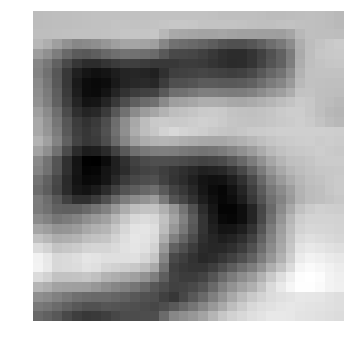

In [9]:
plt.axis('off')
plt.imshow(test_dataset[index].reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap=plt.cm.gray, interpolation='nearest')

测试集分类准确率 71.212128  
77.770142

In [12]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'multi.ckpt')
    #test_prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})
    prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})

In [13]:
prediction

77.770142

In [ ]:
test_labels[index]